# Expected Goals Frequentist Models

In [1]:
import json
import os
import sys
from pathlib import Path

import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from plotnine import *

%load_ext dotenv
%dotenv
PROJECT_DIR=Path(os.environ.get('PROJECT_DIR'))
sys.path.append(str(PROJECT_DIR))

import projects.common.xg.scr.FCPython as FCPython

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

theme_set(theme_bw())
pd.set_option('display.max_columns', 100)
SEED = 919

DATA_FILEPATH = PROJECT_DIR / 'data'  / 'bigger-data' / 'football' / 'events' / 'events_England.json' 
DATA_FILEPATH

PosixPath('/media/david/T7/code/bmcp/bmcp-notes/data/bigger-data/football/events/events_England.json')

+ [Kaggle Data](https://www.kaggle.com/datasets/aleespinosa/soccer-match-event-dataset)
+ **[Figshare data - Version 2 used in this Notebook to match Friends of Tracking Code](https://figshare.com/collections/Soccer_match_event_dataset/4415000/5)**
+ [Nature Paper](https://www.nature.com/articles/s41597-019-0247-7)
+ [Wyscout Event tags](https://support.wyscout.com/matches-wyid-events#10-available-tag-ids)
+ [Github - Exploring spatio-temporal soccer events using public event data](https://github.com/Friends-of-Tracking-Data-FoTD/mapping-match-events-in-Python)
+ [qcut on multiple columns](https://stackoverflow.com/questions/63164115/applying-pd-qcut-on-multiple-columns)
+ [Time of flight relationship to distance](https://www.studocu.com/en-us/messages/question/2801482/in-projectile-motion-is-there-a-direct-relationship-between-time-in-the-air-and-the-range)
+ Friends of Tracking Video Series
    + **[How to Build an Expected Goals Model 1: Model and data](https://www.youtube.com/watch?v=bpjLyFyLlXs)**
    + **[How to Build An Expected Goals Model 2: Statistical fitting](https://www.youtube.com/watch?v=wHOgINJ5g54)**
    + [How to Build An Expected Goals Model 2: Statistical fitting](https://www.youtube.com/watch?v=wHOgINJ5g54)
    + [The Ultimate Guide to Expected Goals](https://www.youtube.com/watch?v=310_eW0hUqQ)
    + [Associated Code - 3xGModel & 5xGModelFit](https://github.com/Friends-of-Tracking-Data-FoTD/SoccermaticsForPython)
    + [Geometry Calculations - The Geometry of Shooting](https://soccermatics.medium.com/the-geometry-of-shooting-ae7a67fdf760)

In [3]:
# https://stackoverflow.com/questions/52795561/flattening-nested-json-in-pandas-data-frame
def flatten_json(nested_json, exclude=['']):
    """Flatten json object with nested keys into a single level.
        Args:
            nested_json: A nested json object.
            exclude: Keys to exclude from output.
        Returns:
            The flattened json object if successful, None otherwise.
    """
    out = {}

    def flatten(x, name='', exclude=exclude):
        if type(x) is dict:
            for a in x:
                if a not in exclude: flatten(x[a], name + a + '_')
        elif type(x) is list:
            i = 0
            for a in x:
                flatten(a, name + str(i) + '_')
                i += 1
        else:
            out[name[:-1]] = x

    flatten(nested_json)
    return out

In [4]:
with open(str(DATA_FILEPATH)) as f:
    events_dict = {'events':json.load(f)}
# sample event
events_dict['events'][0]

{'eventId': 8,
 'subEventName': 'Simple pass',
 'tags': [{'id': 1801}],
 'playerId': 25413,
 'positions': [{'y': 49, 'x': 49}, {'y': 78, 'x': 31}],
 'matchId': 2499719,
 'eventName': 'Pass',
 'teamId': 1609,
 'matchPeriod': '1H',
 'eventSec': 2.7586489999999912,
 'subEventId': 85,
 'id': 177959171}

In [5]:
df_orig = pd.DataFrame([flatten_json(x) for x in events_dict['events']])
df_orig['subEventName'] = df_orig['subEventName'].str.replace(' ', '', regex=True)
df_orig

,eventId,subEventName,tags_0_id,playerId,positions_0_y,positions_0_x,positions_1_y,positions_1_x,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id,tags_1_id,tags_2_id,tags_3_id,tags_4_id,tags_5_id
0,8,Simplepass,1801.0,25413,49,49,78.0,31.0,2499719,Pass,1609,1H,2.758649,85,177959171,NaN,NaN,NaN,NaN,NaN
1,8,Highpass,1801.0,370224,78,31,75.0,51.0,2499719,Pass,1609,1H,4.946850,83,177959172,NaN,NaN,NaN,NaN,NaN
2,8,Headpass,1801.0,3319,75,51,71.0,35.0,2499719,Pass,1609,1H,6.542188,82,177959173,NaN,NaN,NaN,NaN,NaN
3,8,Headpass,1801.0,120339,71,35,95.0,41.0,2499719,Pass,1609,1H,8.143395,82,177959174,NaN,NaN,NaN,NaN,NaN
4,8,Simplepass,1801.0,167145,95,41,88.0,72.0,2499719,Pass,1609,1H,10.302366,85,177959175,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
643145,5,Balloutofthefield,NaN,0,32,0,100.0,100.0,2500098,Interruption,1623,2H,2796.732525,50,251596409,NaN,NaN,NaN,NaN,NaN
643146,3,Corner,302.0,70965,100,100,47.0,88.0,2500098,Free Kick,1633,2H,2829.821084,30,251596232,801.0,1801.0,NaN,NaN,NaN
643147,1,Airduel,701.0,7919,53,12,50.0,14.0,2500098,Duel,1623,2H,2831.211419,10,251596410,1802.0,NaN,NaN,NaN,NaN
643148,1,Airduel,703.0,8005,47,88,50.0,86.0,2500098,Duel,1633,2H,2832.434399,10,251596234,1801.0,NaN,NaN,NaN,NaN


In [6]:
df_orig['subEventName'].value_counts()

Simplepass               251405
Groundattackingduel       53859
Grounddefendingduel       53737
Airduel                   37760
Touch                     34409
Groundlooseballduel       31332
Balloutofthefield         27331
Highpass                  25067
Headpass                  21332
Throwin                   17050
Cross                     12251
Clearance                 11784
Launch                    10247
Shot                       8451
Foul                       7522
FreeKick                   7279
Goalkick                   6061
Smartpass                  5881
Acceleration               4892
Corner                     3910
Handpass                   2474
Reflexes                   2124
Freekickcross              1693
                           1558
Goalkeeperleavingline      1266
Saveattempt                1225
Freekickshot                350
Handfoul                    275
Whistle                     204
Outofgamefoul                97
Protest                      84
Penalty 

In [7]:
shots_orig = df_orig.copy()
# Keep Shot events
shots_orig = shots_orig[shots_orig['subEventName']=='Shot'].reset_index(drop=True)
# Wyscout event tags - https://support.wyscout.com/matches-wyid-events#10-available-tag-ids
# identify goal events
crit1 = shots_orig['tags_0_id']==101
crit2 = shots_orig['tags_1_id']==101 
crit3 = shots_orig['tags_2_id']==101 
crit4 = shots_orig['tags_3_id']==101 
crit5 = shots_orig['tags_4_id']==101
crit6 = shots_orig['tags_5_id']==101 
shots_orig['is_goal'] = (shots_orig[crit1 | crit2 | crit3 | crit4 | crit5]).any(1)
shots_orig['is_goal'] = shots_orig['is_goal'].fillna(False).astype(int)
# Identify header events
crit1 = shots_orig['tags_0_id']==403
crit2 = shots_orig['tags_1_id']==403
crit3 = shots_orig['tags_2_id']==403
crit4 = shots_orig['tags_3_id']==403
crit5 = shots_orig['tags_4_id']==403
crit6 = shots_orig['tags_5_id']==403
shots_orig['is_header'] = (shots_orig[crit1 | crit2 | crit3 | crit4 | crit5]).any(1)
shots_orig['is_header'] = shots_orig['is_header'].fillna(False).astype(int)
# Pitch Position calcs
shots_orig['X'] = 100 - shots_orig['positions_0_x']
shots_orig['Y'] = shots_orig['positions_0_y']
shots_orig['C'] = abs(shots_orig['positions_0_y'] - 50)

x = shots_orig['X'].values*(105/100)
y = shots_orig['C'].values*(65/100)
shots_orig['Distance'] = np.sqrt(x**2 + y**2)
a = np.arctan((7.32 *x) /(x**2 + y**2 - (7.32/2)**2))
shots_orig['Angle'] = a
shots_orig['Angle'] = np.where(shots_orig['Angle'] < 0, shots_orig['Angle'] + np.pi, shots_orig['Angle']) 
shots_orig['angle_deg'] = np.rad2deg(shots_orig['Angle'])
# lines 52 to 55 in https://github.com/Friends-of-Tracking-Data-FoTD/SoccermaticsForPython/blob/master/3xGModel.py commit on May 3, 2020
# https://github.com/Friends-of-Tracking-Data-FoTD/SoccermaticsForPython/commit/330dcbe49f57dd14d18168513c19d1d47c25408c
# print(a)
# if a<0:
# #     a=np.pi+a
# shots_orig['Angle'] = a
shots_orig

,eventId,subEventName,tags_0_id,playerId,positions_0_y,positions_0_x,positions_1_y,positions_1_x,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id,tags_1_id,tags_2_id,tags_3_id,tags_4_id,tags_5_id,is_goal,is_header,X,Y,C,Distance,Angle,angle_deg
0,10,Shot,101.0,25413,41,88,0.0,0.0,2499719,Shot,1609,1H,94.595788,100,177959212,402.0,201.0,1205.0,1801.0,NaN,1,0,12,41,9,13.891814,0.474451,27.184065
1,10,Shot,401.0,26150,52,85,100.0,100.0,2499719,Shot,1631,1H,179.854785,100,177959247,201.0,1211.0,1802.0,NaN,NaN,0,0,15,52,2,15.803560,0.453823,26.002161
2,10,Shot,101.0,14763,52,96,100.0,100.0,2499719,Shot,1631,1H,254.745027,100,177959280,403.0,201.0,1207.0,1801.0,NaN,1,1,4,52,2,4.396590,1.380115,79.074774
3,10,Shot,401.0,7868,33,81,0.0,0.0,2499719,Shot,1609,1H,425.824035,100,177959289,201.0,1215.0,1802.0,NaN,NaN,0,0,19,33,17,22.805811,0.280597,16.077018
4,10,Shot,402.0,7868,30,75,0.0,0.0,2499719,Shot,1609,1H,815.462015,100,177959429,201.0,1205.0,1801.0,NaN,NaN,0,0,25,30,20,29.292704,0.223680,12.815892
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8446,10,Shot,401.0,8561,45,72,0.0,0.0,2500098,Shot,1633,2H,1972.969422,100,251596053,1212.0,1802.0,NaN,NaN,NaN,0,0,28,45,5,29.579089,0.244789,14.025369
8447,10,Shot,101.0,41174,33,86,0.0,0.0,2500098,Shot,1633,2H,2193.887080,100,251596096,402.0,201.0,1209.0,1801.0,NaN,1,0,14,33,17,18.390011,0.319916,18.329841
8448,10,Shot,402.0,7879,62,88,100.0,100.0,2500098,Shot,1623,2H,2377.197700,100,251596357,201.0,1201.0,1801.0,NaN,NaN,0,0,12,62,12,14.818907,0.420593,24.098221
8449,10,Shot,402.0,145692,38,92,100.0,100.0,2500098,Shot,1623,2H,2381.481625,100,251596359,201.0,1206.0,1801.0,NaN,NaN,0,0,8,38,12,11.462984,0.480357,27.522457


In [8]:
shots_orig[shots_orig['Angle'] < 0]

,eventId,subEventName,tags_0_id,playerId,positions_0_y,positions_0_x,positions_1_y,positions_1_x,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id,tags_1_id,tags_2_id,tags_3_id,tags_4_id,tags_5_id,is_goal,is_header,X,Y,C,Distance,Angle,angle_deg


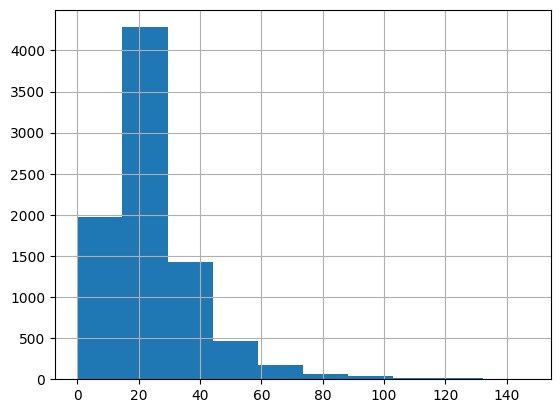

In [9]:
shots_orig['angle_deg'].hist();

In [10]:
shots_df = shots_orig.copy()
shots_df = shots_df[shots_df['is_header']==0].reset_index()
shots_df = shots_df[['X', 'Y', 'C', 'Distance', 'Angle', 'angle_deg', 'is_goal']]
shots_df

,X,Y,C,Distance,Angle,angle_deg,is_goal
0,12,41,9,13.891814,0.474451,27.184065,1
1,15,52,2,15.803560,0.453823,26.002161,0
2,19,33,17,22.805811,0.280597,16.077018,0
3,25,30,20,29.292704,0.223680,12.815892,0
4,10,39,11,12.703248,0.479051,27.447608,0
...,...,...,...,...,...,...,...
7129,14,40,10,16.072959,0.413920,23.715869,0
7130,28,45,5,29.579089,0.244789,14.025369,0
7131,14,33,17,18.390011,0.319916,18.329841,1
7132,12,62,12,14.818907,0.420593,24.098221,0


In [11]:
H_Shot=np.histogram2d(shots_df['X'], shots_df['Y'],bins=50,range=[[0, 100],[0, 100]])
goals_only=shots_df[shots_df['is_goal']==1]
H_Goal=np.histogram2d(goals_only['X'], goals_only['Y'],bins=50,range=[[0, 100],[0, 100]])
# Divide warning
prob_goal = H_Goal[0]/H_Shot[0]

/tmp/ipykernel_2877934/4284266854.py:5: RuntimeWarning: invalid value encountered in true_divide


In [12]:
H_Shot[0][10]

array([ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  4.,  4.,  9.,
       12., 16., 21., 27., 26., 27., 21., 19., 17., 18., 21., 15., 17.,
       18., 20., 21., 19., 20., 14., 19., 15., 19.,  9., 16.,  8.,  4.,
        3.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

## Number of Shots

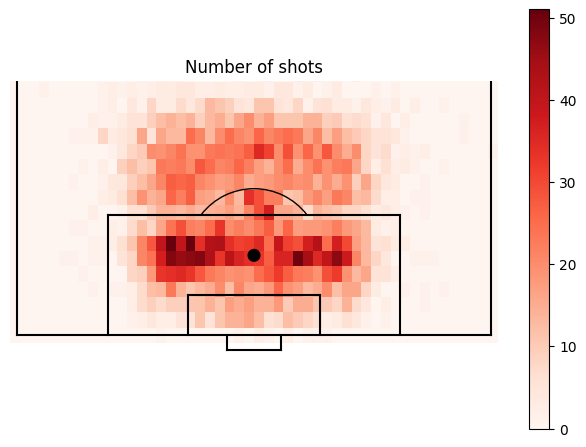

In [13]:
#Plot the number of shots from different points
(fig,ax) = FCPython.createGoalMouth()
pos=ax.imshow(H_Shot[0], extent=[-1,66,104,-1], aspect='auto',cmap=plt.cm.Reds)
fig.colorbar(pos, ax=ax)
ax.set_title('Number of shots')
plt.xlim((-1,66))
plt.ylim((-3,35))
plt.tight_layout()
plt.gca().set_aspect('equal', adjustable='box')
plt.show()
# fig.savefig('Output/NumberOfShots.pdf', dpi=None, bbox_inches="tight")  

## Number of Goals

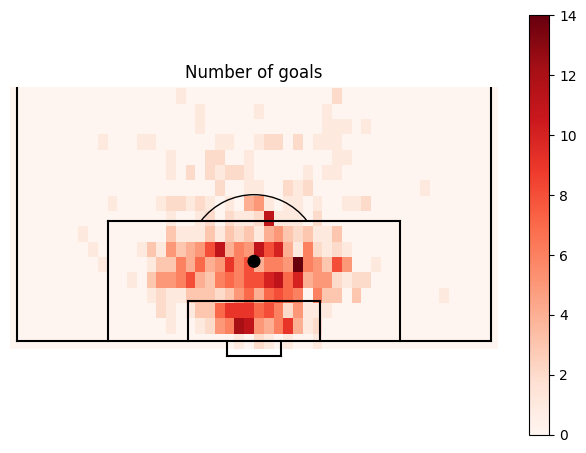

In [14]:
#Plot the number of GOALS from different points
(fig,ax) = FCPython.createGoalMouth()
pos=ax.imshow(H_Goal[0], extent=[-1,66,104,-1], aspect='auto',cmap=plt.cm.Reds)
fig.colorbar(pos, ax=ax)
ax.set_title('Number of goals')
plt.xlim((-1,66))
plt.ylim((-3,35))
plt.tight_layout()
plt.gca().set_aspect('equal', adjustable='box')
plt.show()
# fig.savefig('Output/NumberOfGoals.pdf', dpi=None, bbox_inches="tight")   

## Probability of a Goal

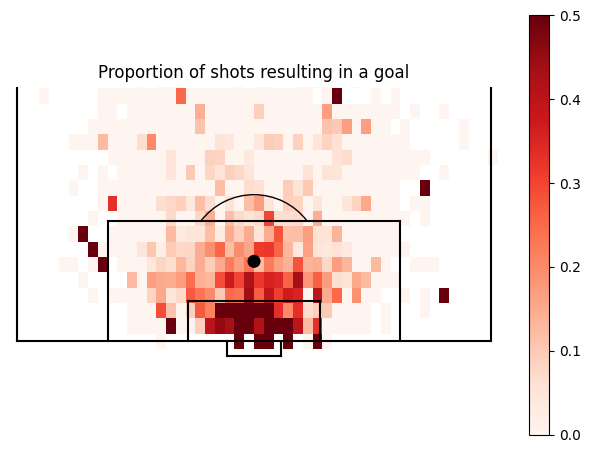

In [15]:
#Plot the probability of scoring from different points
(fig,ax) = FCPython.createGoalMouth()
pos=ax.imshow(prob_goal, extent=[-1,66,104,-1], aspect='auto',cmap=plt.cm.Reds,vmin=0, vmax=0.5)
fig.colorbar(pos, ax=ax)
ax.set_title('Proportion of shots resulting in a goal')
plt.xlim((-1,66))
plt.ylim((-3,35))
plt.tight_layout()
plt.gca().set_aspect('equal', adjustable='box')
plt.show()
# fig.savefig('Output/ProbabilityOfScoring.pdf', dpi=None, bbox_inches="tight")  

## Probability of Goal with Minimum Number of Shots Threshold

In [16]:
min_n_shots = 4
h_shots = H_Shot[0]
h_shots[h_shots < min_n_shots] = 0
prob_goal = H_Goal[0]/h_shots
h_shots[10]

/tmp/ipykernel_2877934/85519628.py:4: RuntimeWarning: divide by zero encountered in true_divide
/tmp/ipykernel_2877934/85519628.py:4: RuntimeWarning: invalid value encountered in true_divide


array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  4.,  4.,  9.,
       12., 16., 21., 27., 26., 27., 21., 19., 17., 18., 21., 15., 17.,
       18., 20., 21., 19., 20., 14., 19., 15., 19.,  9., 16.,  8.,  4.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

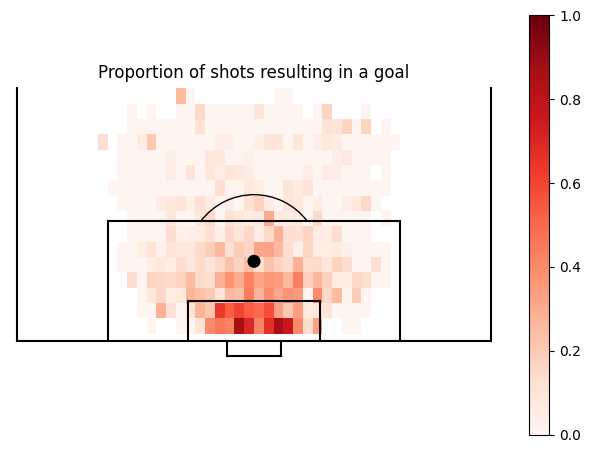

In [17]:
#Plot the probability of scoring from different points
(fig,ax) = FCPython.createGoalMouth()
pos=ax.imshow(prob_goal, extent=[-1,66,104,-1], aspect='auto',cmap=plt.cm.Reds,vmin=0, vmax=1.0)
fig.colorbar(pos, ax=ax)
ax.set_title('Proportion of shots resulting in a goal')
plt.xlim((-1,66))
plt.ylim((-3,35))
plt.tight_layout()
plt.gca().set_aspect('equal', adjustable='box')
plt.show()
# fig.savefig('Output/ProbabilityOfScoring.pdf', dpi=None, bbox_inches="tight")  

TODO
+ Plot of probability of scoring (y) vs shot angle (x) in degrees 20:26 of video
+ Plot of probability of scoring (y) vs distance from goal - meters - (x) 21:49 vid time
+ Alternative pitch divisions

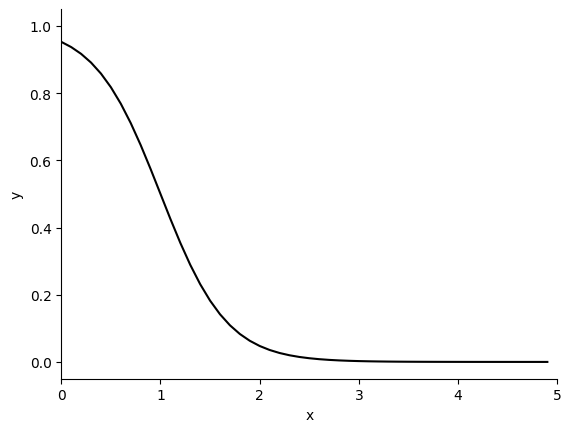

In [18]:
#Plot a logistic curve
b=[3, -3]
x=np.arange(5,step=0.1)

y=1/(1+np.exp(-b[0]-b[1]*x))
# y=1/(1+np.exp(-(b[0]*x+ b[1])))
fig,ax=plt.subplots(num=1)
plt.ylim((-0.05,1.05))
plt.xlim((0,5))
ax.set_ylabel('y')
ax.set_xlabel("x") 
ax.plot(x, y, linestyle='solid', color='black')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

In [19]:
b[0]

3

/tmp/ipykernel_2877934/238752296.py:7: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later


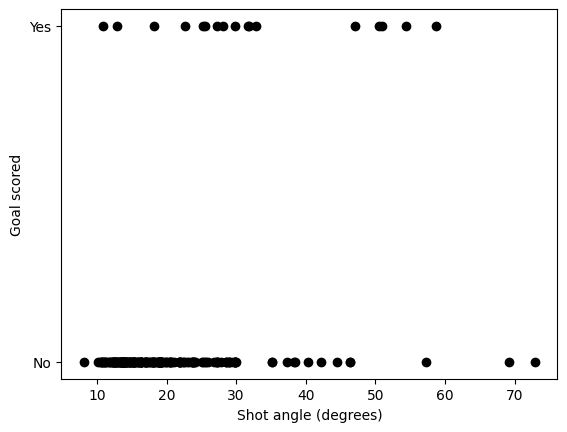

In [20]:
#Get first 200 shots
shots_200 = shots_df.copy()
shots_200=shots_200.iloc[:200]

#Plot first 200 shots goal angle
fig,ax=plt.subplots(num=1)
ax.plot(shots_200['Angle']*180/np.pi, shots_200['is_goal'], linestyle='none', marker= '.', markerSize= 12, color='black')
ax.set_ylabel('Goal scored')
ax.set_xlabel("Shot angle (degrees)")
plt.ylim((-0.05,1.05))
ax.set_yticks([0,1])
ax.set_yticklabels(['No','Yes'])
plt.show()

/tmp/ipykernel_2877934/1534625712.py:5: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_2877934/1534625712.py:9: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later


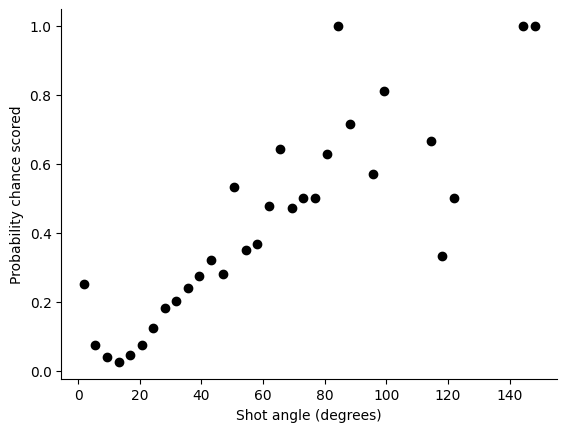

In [21]:
shots_model = shots_df.copy()
#Show empirically how goal angle predicts probability of scoring
shotcount_dist=np.histogram(shots_model['Angle']*180/np.pi,bins=40,range=[0, 150])
goalcount_dist=np.histogram(goals_only['Angle']*180/np.pi,bins=40,range=[0, 150])
prob_goal=np.divide(goalcount_dist[0],shotcount_dist[0])
angle=shotcount_dist[1]
midangle= (angle[:-1] + angle[1:])/2
fig,ax=plt.subplots(num=2)
ax.plot(midangle, prob_goal, linestyle='none', marker= '.', markerSize= 12, color='black')
ax.set_ylabel('Probability chance scored')
ax.set_xlabel("Shot angle (degrees)")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

/tmp/ipykernel_2877934/2264326638.py:5: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_2877934/2264326638.py:9: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later


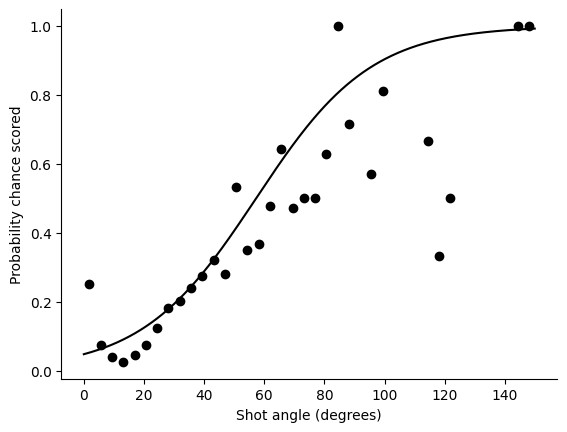

In [22]:
shots_model = shots_df.copy()
#Show empirically how goal angle predicts probability of scoring
shotcount_dist=np.histogram(shots_model['Angle']*180/np.pi,bins=40,range=[0, 150])
goalcount_dist=np.histogram(goals_only['Angle']*180/np.pi,bins=40,range=[0, 150])
prob_goal=np.divide(goalcount_dist[0],shotcount_dist[0])
angle=shotcount_dist[1]
midangle= (angle[:-1] + angle[1:])/2
fig,ax=plt.subplots(num=2)
ax.plot(midangle, prob_goal, linestyle='none', marker= '.', markerSize= 12, color='black')
ax.set_ylabel('Probability chance scored')
ax.set_xlabel("Shot angle (degrees)")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#Now try sigmoid model
#This is a good model but NOT a good way of fitting.
#because each point contains lots of data points
b=[3, -3]
x=np.arange(150,step=0.1)
y=1/(1+np.exp(b[0]+b[1]*x*np.pi/180)) 
ax.plot(x, y, linestyle='solid', color='black')
plt.show()

In [23]:
# #Now lets look at the likelihood of model given data
# xG=1/(1+np.exp(b[0]+b[1]*shots_model['Angle'])) 
# shots_model = shots_model.assign(xG=xG)
# shots_40=shots_model.iloc[:40]
# fig,ax=plt.subplots(num=1)
# ax.plot(shots_40['Angle']*180/np.pi, shots_40['is_goal'], linestyle='none', marker= '.', markerSize= 12, color='black')
# ax.plot(x, y, linestyle='solid', color='black')
# ax.plot(x, 1-y, linestyle='solid', color='black')
# loglikelihood=0
# for item,shot in shots_40.iterrows():
#     ang=shot['Angle']*180/np.pi
#     if shot['is_goal']==1:
#         loglikelihood=loglikelihood+np.log(shot['xG'])
#         ax.plot([ang,ang],[shot['is_goal'],shot['xG']], color='red')
#     else:
#         loglikelihood=loglikelihood+np.log(1 - shot['xG'])
#         ax.plot([ang,ang],[shot['is_goal'],1-shot['xG']], color='blue')

/tmp/ipykernel_2877934/1308186715.py:6: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later


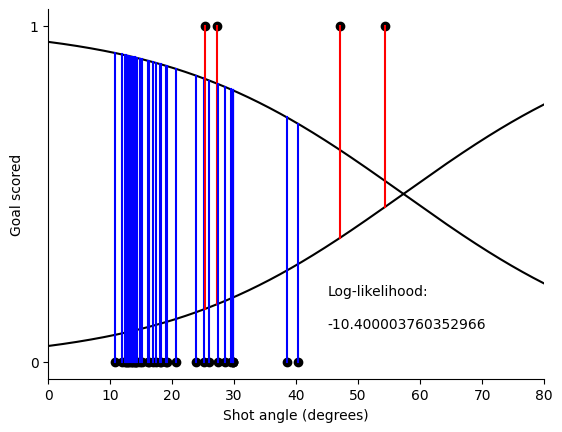

In [24]:
#Now lets look at the likelihood of model given data
xG=1/(1+np.exp(b[0]+b[1]*shots_model['Angle'])) 
shots_model = shots_model.assign(xG=xG)
shots_40=shots_model.iloc[:40]
fig,ax=plt.subplots(num=1)
ax.plot(shots_40['Angle']*180/np.pi, shots_40['is_goal'], linestyle='none', marker= '.', markerSize= 12, color='black')
ax.plot(x, y, linestyle='solid', color='black')
ax.plot(x, 1-y, linestyle='solid', color='black')
loglikelihood=0
for item,shot in shots_40.iterrows():
    ang=shot['Angle']*180/np.pi
    if shot['is_goal']==1:
        loglikelihood=loglikelihood+np.log(shot['xG'])
        ax.plot([ang,ang],[shot['is_goal'],shot['xG']], color='red')
    else:
        loglikelihood=loglikelihood+np.log(1 - shot['xG'])
        ax.plot([ang,ang],[shot['is_goal'],1-shot['xG']], color='blue')
ax.set_ylabel('Goal scored')
ax.set_xlabel("Shot angle (degrees)")
plt.ylim((-0.05,1.05))
plt.xlim((0,80))
plt.text(45,0.2,'Log-likelihood:') 
plt.text(45,0.1,str(loglikelihood))
ax.set_yticks([0,1])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# fig.savefig('Output/LikelihoodExample.pdf', dpi=None, bbox_inches="tight")   
plt.show()

In [25]:
#Make single variable model of angle
#Using logistic regression we find the optimal values of b
#This process minimizes the loglikelihood
test_model = smf.glm(formula="is_goal ~ Angle" , data=shots_model, 
                           family=sm.families.Binomial()).fit()
print(test_model.summary())        
b=test_model.params

                 Generalized Linear Model Regression Results                  
Dep. Variable:                is_goal   No. Observations:                 7134
Model:                            GLM   Df Residuals:                     7132
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2056.3
Date:                Thu, 30 Mar 2023   Deviance:                       4112.7
Time:                        12:42:51   Pearson chi2:                 6.70e+03
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -3.7097      0.085    -43.542      0.0

In [26]:
# b.keys()
# b['Intercept']
b.Intercept

-3.7096668462422486

/tmp/ipykernel_2877934/2976761348.py:4: RuntimeWarning: invalid value encountered in true_divide
/tmp/ipykernel_2877934/2976761348.py:9: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later


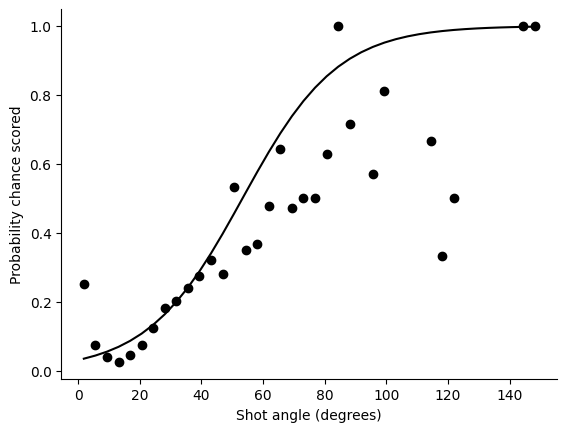

In [27]:
shots_model = shots_df.copy()
shotcount_dist=np.histogram(shots_model['Angle']*180/np.pi,bins=40,range=[0, 150])
goalcount_dist=np.histogram(goals_only['Angle']*180/np.pi,bins=40,range=[0, 150])
prob_goal=np.divide(goalcount_dist[0],shotcount_dist[0])
# original
# xGprob=1/(1+np.exp(b[0]+b[1]*midangle*np.pi/180)) 
xGprob=1/(1+np.exp(b.Angle+b.Intercept*midangle*np.pi/180)) 
fig,ax=plt.subplots(num=1)
ax.plot(midangle, prob_goal, linestyle='none', marker= '.', markerSize= 12, color='black')
ax.plot(midangle, xGprob, linestyle='solid', color='black')
ax.set_ylabel('Probability chance scored')
ax.set_xlabel("Shot angle (degrees)")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()
# fig.savefig('Output/ProbabilityOfScoringAngleFit.pdf', dpi=None, bbox_inches="tight")  

In [28]:
# DATA_FILEPATH = PROJECT_DIR / 'data'  / 'football' / 'events' / 'events_England.json' 
# save_filepath = str(DATA_FILEPATH).replace('events_England.json', 'england_shots.csv')
# shots_df.to_csv(save_filepath, index=False)

TODO
+ Code needs correction from here down

/tmp/ipykernel_2877934/1857774828.py:7: RuntimeWarning: invalid value encountered in true_divide


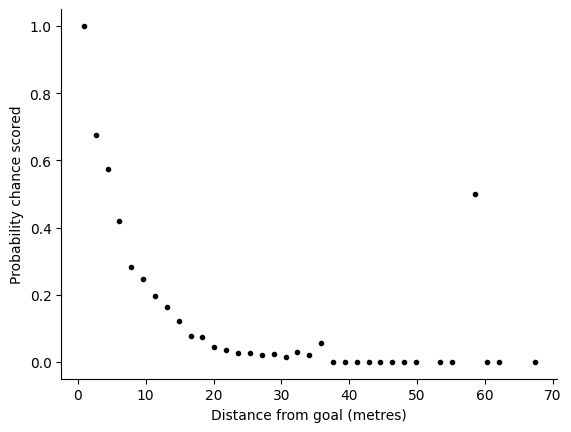

In [29]:
#Now lets look at distance from goal
shots_model = shots_df.copy()

#Show empirically how distance from goal predicts probability of scoring
shotcount_dist=np.histogram(shots_model['Distance'],bins=40,range=[0, 70])
goalcount_dist=np.histogram(goals_only['Distance'],bins=40,range=[0, 70])
prob_goal=np.divide(goalcount_dist[0],shotcount_dist[0])
distance=shotcount_dist[1]
middistance= (distance[:-1] + distance[1:])/2
fig,ax=plt.subplots(num=1)
ax.plot(middistance, prob_goal, linestyle='none', marker= '.', color='black')
ax.set_ylabel('Probability chance scored')
ax.set_xlabel("Distance from goal (metres)")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

In [30]:
#Make single variable model of distance
test_model = smf.glm(formula="is_goal ~ Distance" , data=shots_model, 
                           family=sm.families.Binomial()).fit()
print(test_model.summary())        
b=test_model.params
xGprob=1/(1+np.exp(b[0]+b[1]*middistance)) 
ax.plot(middistance, xGprob, linestyle='solid', color='black')
plt.show()
# fig.savefig('Output/ProbabilityOfScoringDistance.pdf', dpi=None, bbox_inches="tight")   

                 Generalized Linear Model Regression Results                  
Dep. Variable:                is_goal   No. Observations:                 7134
Model:                            GLM   Df Residuals:                     7132
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2010.7
Date:                Thu, 30 Mar 2023   Deviance:                       4021.3
Time:                        12:42:51   Pearson chi2:                 1.90e+04
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5282      0.107      4.914      0.0

                 Generalized Linear Model Regression Results                  
Dep. Variable:                is_goal   No. Observations:                 7134
Model:                            GLM   Df Residuals:                     7131
Model Family:                Binomial   Df Model:                            2
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1992.2
Date:                Thu, 30 Mar 2023   Deviance:                       3984.3
Time:                        12:42:51   Pearson chi2:                 7.12e+03
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.3796      0.158      8.736      0.0

/tmp/ipykernel_2877934/493376266.py:5: RuntimeWarning: invalid value encountered in true_divide


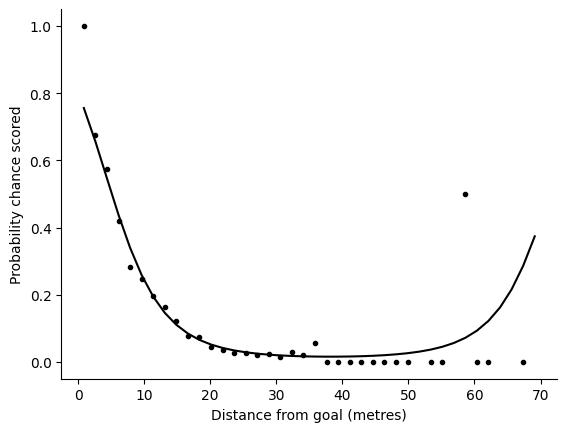

In [31]:
shots_model = shots_df.copy()
#Show empirically how distance from goal predicts probability of scoring
shotcount_dist=np.histogram(shots_model['Distance'],bins=40,range=[0, 70])
goalcount_dist=np.histogram(goals_only['Distance'],bins=40,range=[0, 70])
prob_goal=np.divide(goalcount_dist[0],shotcount_dist[0])

# shotcount_dist=np.histogram(shots_model['Distance'],bins=40,range=[0, 70])
# goalcount_dist=np.histogram(goals_only['Distance'],bins=40,range=[0, 70])
# prob_goal=np.divide(goalcount_dist[0],shotcount_dist[0])
distance=shotcount_dist[1]
middistance= (distance[:-1] + distance[1:])/2


#Adding distance squared
squaredD = shots_model['Distance']**2
shots_model = shots_model.assign(D2=squaredD)
test_model = smf.glm(formula="is_goal ~ Distance + D2" , data=shots_model, 
                           family=sm.families.Binomial()).fit()
print(test_model.summary())        
b=test_model.params
xGprob=1/(1+np.exp(-(b.Intercept+b.Distance*middistance+b.D2*pow(middistance,2)))) 
fig,ax=plt.subplots(num=1)
ax.plot(middistance, prob_goal, linestyle='none', marker= '.', color='black')
ax.set_ylabel('Probability chance scored')
ax.set_xlabel("Distance from goal (metres)")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.plot(middistance, xGprob, linestyle='solid', color='black')
plt.show()
# fig.savefig('Output/ProbabilityOfScoringDistanceSquared.pdf', dpi=None, bbox_inches="tight") 

In [32]:
#Adding even more variables to the model.
shots_model = shots_df.copy()
squaredX = shots_model['X']**2
shots_model = shots_model.assign(X2=squaredX)
squaredC = shots_model['C']**2
shots_model = shots_model.assign(C2=squaredC)
AX = shots_model['Angle']*shots_model['X']
shots_model = shots_model.assign(AX=AX)

In [33]:
# A general model for fitting goal probability
# List the model variables you want here
model_variables = ['Angle','Distance','X','C']
model=''
for v in model_variables[:-1]:
    model = model  + v + ' + '
model = model + model_variables[-1]

In [34]:
#Fit the model
test_model = smf.glm(formula="is_goal ~ " + model, data=shots_model, 
                           family=sm.families.Binomial()).fit()
print(test_model.summary())        
b=test_model.params

                 Generalized Linear Model Regression Results                  
Dep. Variable:                is_goal   No. Observations:                 7134
Model:                            GLM   Df Residuals:                     7129
Model Family:                Binomial   Df Model:                            4
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1988.0
Date:                Thu, 30 Mar 2023   Deviance:                       3976.0
Time:                        12:42:51   Pearson chi2:                 9.33e+03
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.5114      0.305     -1.676      0.0

In [35]:
#Return xG value for more general model
def calculate_xG(sh):
    bsum=b[0]
    for i,v in enumerate(model_variables):
        bsum=bsum+b[i+1]*sh[v]
    xG = 1/(1+np.exp(-(bsum)))
    return xG   

In [36]:
#Add an xG to my dataframe
xG=shots_model.apply(calculate_xG, axis=1) 
shots_model = shots_model.assign(xG=xG)

In [37]:
#Create a 2D map of xG
pgoal_2d=np.zeros((65,65))
for x in range(65):
    for y in range(65):
        sh=dict()
        a = np.arctan(7.32 *x /(x**2 + abs(y-65/2)**2 - (7.32/2)**2))
        if a<0:
            a = np.pi + a
        sh['Angle'] = a
        sh['Distance'] = np.sqrt(x**2 + abs(y-65/2)**2)
        sh['D2'] = x**2 + abs(y-65/2)**2
        sh['X'] = x
        sh['AX'] = x*a
        sh['X2'] = x**2
        sh['C'] = abs(y-65/2)
        sh['C2'] = (y-65/2)**2
        
        pgoal_2d[x,y] =  calculate_xG(sh)

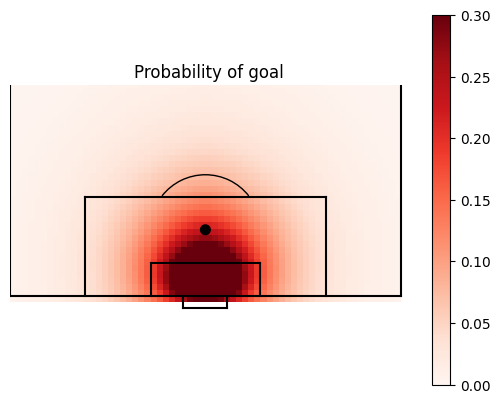

In [38]:
(fig,ax) = FCPython.createGoalMouth()
pos=ax.imshow(pgoal_2d, extent=[-1,65,65,-1], aspect='auto',cmap=plt.cm.Reds,vmin=0, vmax=0.3)
fig.colorbar(pos, ax=ax)
ax.set_title('Probability of goal')
plt.xlim((0,66))
plt.ylim((-3,35))
plt.gca().set_aspect('equal', adjustable='box')
plt.show()
# fig.savefig('Output/goalprobfor_' + model  + '.pdf', dpi=None, bbox_inches="tight")   